For this program, I am going to use distance threshold to define the edges for GNN.
And create the edges between the nodes.
Then using created GNN model, nodes and edges to train the GNN.
Finally, using Accuarcy, Precision, Recall Score, F1 Score to evaluate the performance.

In [12]:
import lime
import torch
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import lime.lime_tabular
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Create the GNN model.
This is still the basic model, which need to further optimized.

In [13]:
## Create GNN Model
class GCNModel(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GCNConv(64, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim = 1)

# Convert your torch model's prediction to work with LIME
def gnn_predict_proba(data):
    # data here is expected to be a numpy array for compatibility with LIME
    data_tensor = torch.tensor(data, dtype=torch.float)
    edge_index = torch.tensor([[i, j] for i in range(data_tensor.shape[0]) for j in range(data_tensor.shape[0])], dtype=torch.long).t().contiguous()
    output = model(Data(x=data_tensor, edge_index=edge_index))
    # Converting log probabilities to probabilities for LIME
    proba = F.softmax(output, dim=1).detach().numpy()
    return proba
    
def visualize_subgraph(edge_index, num_nodes):
    """
    Visualize a subgraph consisting of 'num_nodes' nodes and their corresponding edges.
    
    Parameters:
    - edge_index: Tensor of shape (2, num_edges), representing the edges of the full graph.
    - num_nodes: The number of nodes to include in the subgraph.
    """
    ## Create a null graph of NetworkX
    G = nx.Graph()

    ## Put the node into the graph
    G.add_nodes_from(range(num_nodes))

    ## According to the number of nodes in the graph, adding the edges into it
    for i, j in edge_index.t().tolist():
        if i < num_nodes and j < num_nodes:
            G.add_edge(i, j)

    ## Plot it
    plt.figure(figsize=(12, 8))
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, edge_color='k')
    plt.title(f'Subgraph with {num_nodes} Nodes')
    plt.show()
    #nx.write_gexf(G, "your_graph.gexf")

# Generate a complete edge index for a fully connected graph
def create_fully_connected_edge_index(num_nodes):
    edge_index = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                edge_index.append([i, j])
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

This step is to load the data and extract the features and labels.

In [14]:
## Loading the Data
InputData = pd.read_csv('Data/Dataset_spine_clean.csv')

## Extract the features of spine data
node_features = torch.tensor(InputData.iloc[:, 1:13].values, dtype=torch.float)

## Getting the state label
labels_string = InputData.iloc[:, 13].values
labels = torch.tensor([1 if label == 'Normal' else 0 for label in labels_string], dtype=torch.long)

## Splitting
X_train, X_test, y_train, y_test = train_test_split(node_features, labels,
                                                    test_size = 0.2, random_state = 42)

# Use the number of training nodes to generate the edge index
num_nodes = X_train.shape[0]
train_edge_index = create_fully_connected_edge_index(num_nodes)
test_edge_index = create_fully_connected_edge_index(X_test.shape[0])
##test_edge_index = torch.tensor([[i, i] for i in range(len(X_test))], dtype = torch.long).t().contiguous()

# Create Data objects
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=train_edge_index, y=y_train)
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=test_edge_index, y=y_test)

/var/folders/lh/32h1r4516z9gqrzcfcpq0gd40000gq/T/ipykernel_1827/2858566000.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=train_edge_index, y=y_train)
/var/folders/lh/32h1r4516z9gqrzcfcpq0gd40000gq/T/ipykernel_1827/2858566000.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=test_edge_index, y=y_test)


For this step, I am going to train the GNN model.

In [15]:
model = GCNModel(num_node_features = 12, num_classes = 2)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=5e-4)

## Define the list to contain the loss for visualizing step
loss_values = []

## Training
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(train_data)
    loss = F.nll_loss(out, train_data.y)
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

Epoch 1, Loss: 7.952552318572998
Epoch 2, Loss: 5.182984352111816
Epoch 3, Loss: 2.4414732456207275
Epoch 4, Loss: 0.6395869255065918
Epoch 5, Loss: 1.3380581140518188
Epoch 6, Loss: 2.061347246170044
Epoch 7, Loss: 2.4832491874694824
Epoch 8, Loss: 2.6608645915985107
Epoch 9, Loss: 2.64284086227417
Epoch 10, Loss: 2.465501308441162
Epoch 11, Loss: 2.1567609310150146
Epoch 12, Loss: 1.740268588066101
Epoch 13, Loss: 1.2463816404342651
Epoch 14, Loss: 0.7721635699272156
Epoch 15, Loss: 0.6818953156471252
Epoch 16, Loss: 1.1566828489303589
Epoch 17, Loss: 1.5066030025482178
Epoch 18, Loss: 1.456629753112793
Epoch 19, Loss: 1.0995744466781616
Epoch 20, Loss: 0.7198230028152466
Epoch 21, Loss: 0.6519458889961243
Epoch 22, Loss: 0.822283148765564
Epoch 23, Loss: 0.995539128780365
Epoch 24, Loss: 1.0804526805877686
Epoch 25, Loss: 1.0630767345428467
Epoch 26, Loss: 0.9569628238677979
Epoch 27, Loss: 0.7980297207832336
Epoch 28, Loss: 0.6607626676559448
Epoch 29, Loss: 0.651093602180481
Epoch

In [16]:
## Evaluation
model.eval()
_, pred = model(test_data).max(dim = 1)
test_pred = pred.numpy()

test_accuarcy = accuracy_score(y_test, test_pred)
print(f'Test Accuarcy: {test_accuarcy:.4f}')

test_precision = precision_score(y_test, test_pred, average='macro')
print(f'Test Precision: {test_precision:.4f}')

test_recall = recall_score(y_test, test_pred, average='macro')
print(f'Test Recall: {test_recall:.4f}')

test_f1 = f1_score(y_test, test_pred, average='macro')
print(f'Test F1 Score: {test_f1:.4f}')

Test Accuarcy: 0.7097
Test Precision: 0.3548
Test Recall: 0.5000
Test F1 Score: 0.4151


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


For this step, I am going to visualize the training process and the evaluation score.

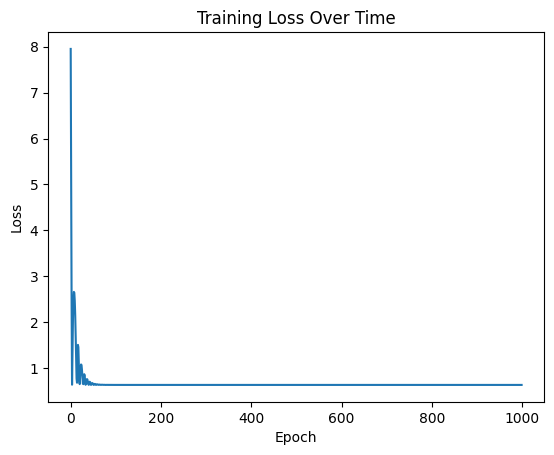

In [17]:
## Plot the loss
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

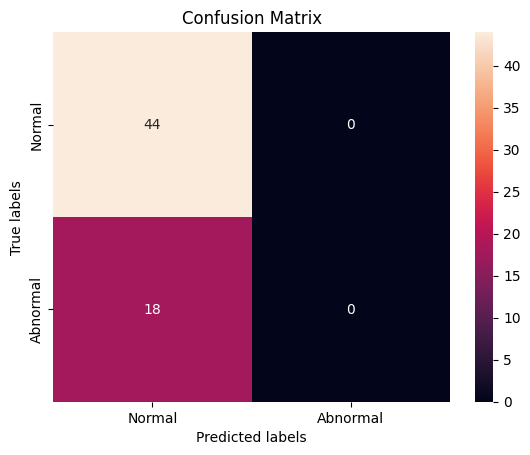

In [18]:
## Plot the confusion matrix
cm = confusion_matrix(y_test.numpy(), pred.numpy())
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

For this step, I am going to visualize the GNN model by plot.
This is still very simple graph. Need more improvement.

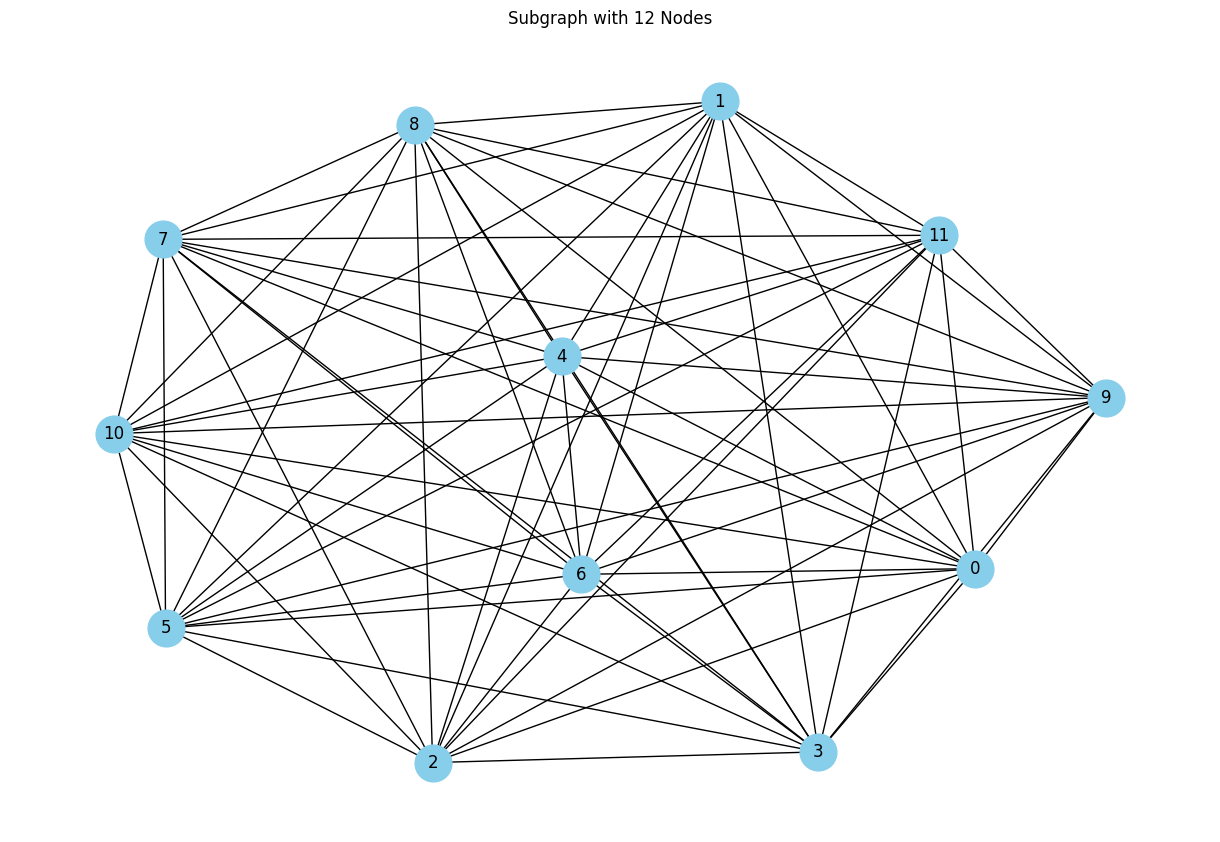

In [19]:
# Input the number of nodes and the related edges, then visulize the nural network
visualize_subgraph(train_edge_index, num_nodes=12)

For the following step, I am going to plot Receiver Operating Characteristic (ROC).
And compute Area Under Curve (AUC) for evaluate the performance of my model.

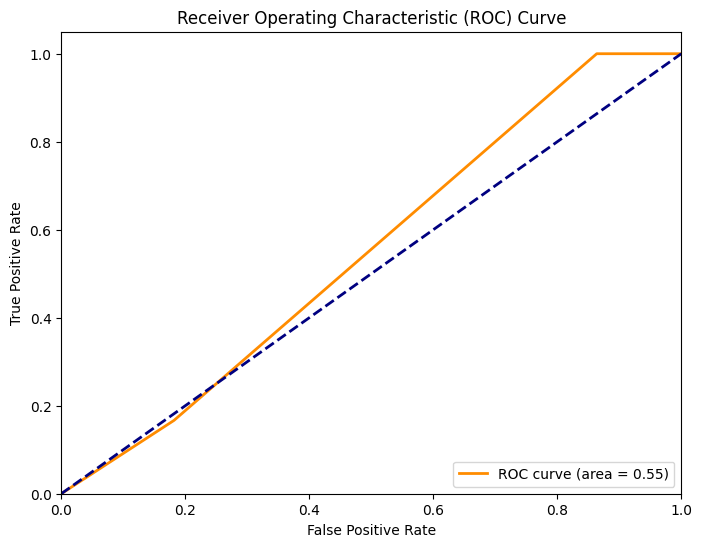

In [20]:
# Probability of prediction
pred_probs = torch.softmax(model(test_data).detach(), dim=1)[:, 1].numpy()

# Compute the ROC
fpr, tpr, thresholds = roc_curve(y_test.numpy(), pred_probs)

# Calculating the AUC
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [21]:
# Prepare the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data = X_train.numpy(),  # Ensure the data is float
    feature_names = ["pelvic_incidence", "pelvic_tilt", "lumbar_lordosis_angle", "sacral_slope", "pelvic_radius",
                     "degree_spondylolisthesis", "pelvic_slope", "Direct_tilt", "thoracic_slope", "cervical_tilt",
                     "sacrum_angle", "scoliosis_slope"],
    class_names=['Normal', 'Abnormal'],
    mode='classification'
)

# Select an instance to explain
i = np.random.randint(0, X_test.shape[0])  # Randomly select an instance
instance = X_test[i].numpy()
exp = explainer.explain_instance(instance, gnn_predict_proba, num_features=12)

# Display the explanation in the notebook
exp.show_in_notebook(show_table=True, show_all=False)

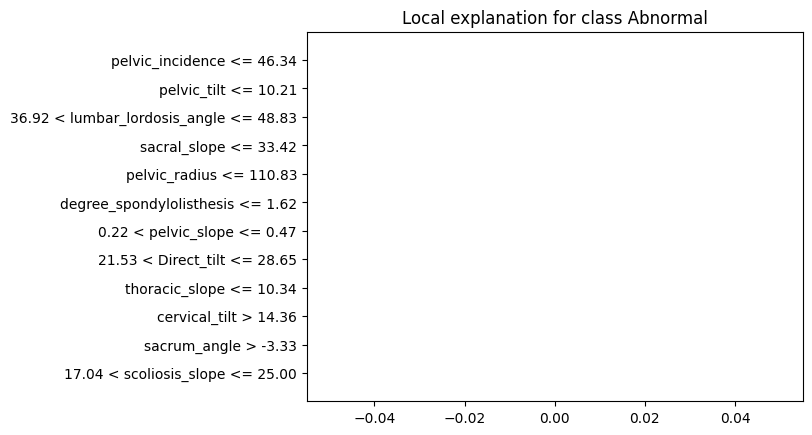

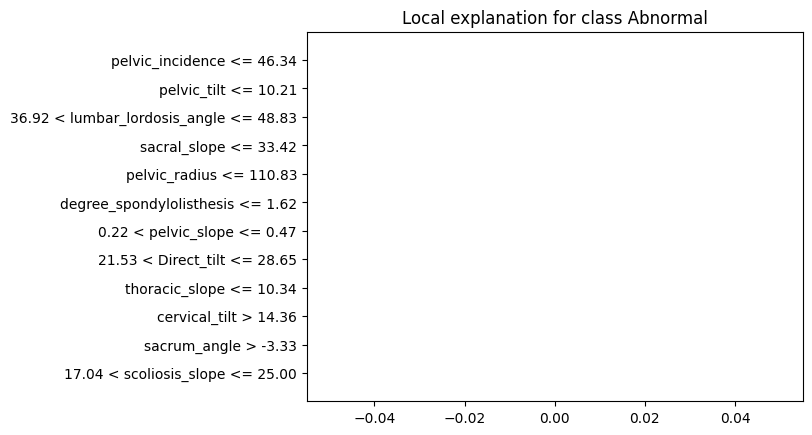

In [22]:
exp.as_pyplot_figure()